# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from 
1) Yandex-disk [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
data = pd.read_csv("week02_classification/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

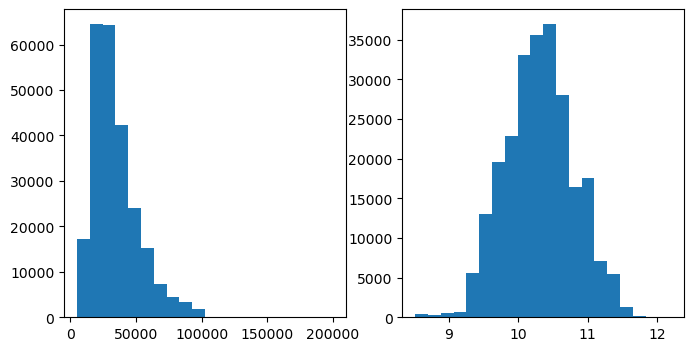

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
8545,65205713,SEO Manager,"SEO Manager Nottingham **** 30,000 My client ...","Nottingham, Nottinghamshire",Nottingham,NaN,permanent,Pytec IT Recruitment,"PR, Advertising & Marketing Jobs","25000 - 30000/annum 25,000 - 30,000 + Bens",27500,cv-library.co.uk,10.221977
58318,68687844,Learner Recruitment Consultant / Employer Enga...,Learner Recruitment Consultant / Business Deve...,"Halifax, West Yorkshire West Yorkshire Yorkshire",Halifax,NaN,permanent,KM Education Recruitment,HR & Recruitment Jobs,"From 18,000 to 18,000 per annum",18000,totaljobs.com,9.798182
226765,72442613,Senior/Principal Structural Engineer OHL,My Client maintains and upgrades services acro...,Derby Derbyshire East Midlands,Derby,NaN,permanent,Hays,Engineering Jobs,30000.00 - 40000.00 per annum,35000,totaljobs.com,10.463132


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][11])

Raw text:
PROJECT ENGINEER PHAMACEUTICAL, c****  Excellent Benefits, Oxfordshire ****/****/mg PROJECT ENGINEER : JOB ROLE: Responsible for execution of Continuous improvement and compliance projects. Responsible too for subprojects related to introduction of new products and processes in order to meet strategic business plans.The position is jointly responsible fo reporting of designated capital and expenses (actual Vs. Plan) associated with implementation of new process equipment or modifications to Existing process equipment. PROJECT ENGINEER: KEY RESPONSIBILITIES: Manage project tasks & deliverables within agreed time, cost, quality Responsbile for process equipment validation, material validation, remediation activity Maintain effectiveness of Quality System in accordance with corporate requirements Effective liaison with Engineering functions, external suppliers and regulatory bodies PROJECT ENGINEER: SKILLS, EXPERIENCE, QUALIFICATION: Proven problem solving skills to quickly impl

In [7]:
print(data["Title"][:10])

0                          Engineering Systems Analyst
1                              Stress Engineer Glasgow
2                     Modelling and simulation analyst
3    Engineering Systems Analyst / Mathematical Mod...
4           Pioneer, Miser Engineering Systems Analyst
5           Engineering Systems Analyst Water Industry
6            Senior Subsea Pipeline Integrity Engineer
7    RECRUITMENT CONSULTANT  INDUSTRIAL / COMMERCIA...
8    RECRUITMENT CONSULTANT  CONSTRUCTION / TECHNIC...
9                               Subsea Cables Engineer
Name: Title, dtype: object


In [8]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()

def space_div(text):
    return ' '.join(tokenizer.tokenize(str(text).lower()))


data["Title"] = data["Title"].apply(space_div)
data["FullDescription"] = data["FullDescription"].apply(space_div)

Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter
token_counts = Counter()

for i in range(len(data)):
    token_counts.update(data["Title"][i].split(' '))
    token_counts.update(data["FullDescription"][i].split(' '))

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


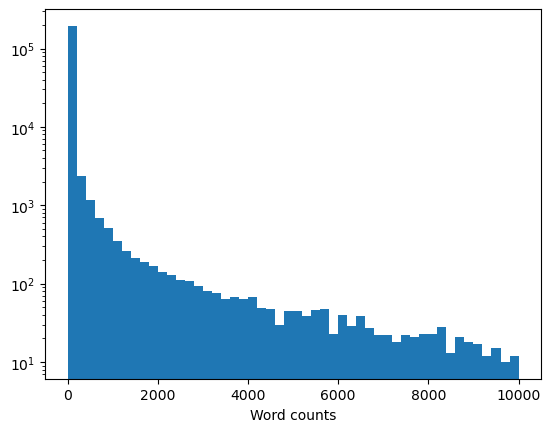

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key, value in token_counts.items() if value >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
data[categorical_columns][:5]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent


In [20]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [21]:
categorical_vectorizer.transform(dict(data.loc[2, categorical_columns])).sum()

5.0

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [24]:
example_batch = make_batch(data_train[:3], max_len=10)
example_batch

{'Title': tensor([[  320,    89,  1657,     1,     1,     1,     1],
         [ 5130,   130,    25,   173,    14,   562, 21820],
         [ 2246,    42,  1433,   109,  9312,  9313,   116]], device='cuda:0'),
 'FullDescription': tensor([[  320,    89,  1657,  2890,    44,   320,    89,  1657,    12,  2890],
         [ 5130,   130,    25,   173,    14,   562, 21820,  1334,   129,     8],
         [   49,    66,   444,    11,    12,    37,   576,    44,    42,  1433]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [25]:
# validating dimensions
emb = nn.Embedding(num_embeddings=len(tokens), embedding_dim=128).to('cuda')
x = emb(example_batch['Title'])
print(x.shape)
x = x.transpose(2, 1)
text_conv_title = nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3).to('cuda')
x = text_conv_title(x)
print(x.shape)
x = torch.amax(x, dim=2)
print(x.shape)

text_conv_descr = nn.Conv1d(in_channels=128, out_channels=32, kernel_size=3).to('cuda')
y = emb(example_batch['FullDescription'])
y = y.transpose(2, 1)
y = text_conv_descr(y)
y = torch.amax(y, dim=2)
print(y.shape)

fc_categorical = nn.Linear(len(categorical_vectorizer.vocabulary_), 32).to('cuda')
z = fc_categorical(example_batch['Categorical'])
print(z.shape)

u = torch.cat([x, y, z], dim=1)
print(u.shape)

final_fc_input_dim = 32 * 3
fc = nn.Linear(final_fc_input_dim, 1).to('cuda')

u = fc(u)
print(u.shape)

u = u.view(-1)
print(u.shape)


torch.Size([3, 7, 128])
torch.Size([3, 32, 5])
torch.Size([3, 32])
torch.Size([3, 32])
torch.Size([3, 32])
torch.Size([3, 96])
torch.Size([3, 1])
torch.Size([3])


In [26]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), embedding_dim=100):
        super().__init__()
        # text convolution kernels
        self.kernel_size = 3
        self.embedding_dim = embedding_dim
        self.conv_out_dim_title = 8
        self.conv_out_dim_descr = 8
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=self.embedding_dim)
        self.text_conv_title = nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.conv_out_dim_title, kernel_size=self.kernel_size)
        self.text_conv_descr = nn.Conv1d(in_channels=self.embedding_dim, out_channels=self.conv_out_dim_descr, kernel_size=self.kernel_size)

        # categorical kernels
        self.categorical_out_dim = 8
        self.fc_categorical = nn.Linear(n_cat_features, self.categorical_out_dim)

        # final linear layer
        self.final_fc_input_dim = self.conv_out_dim_title + self.conv_out_dim_descr + self.categorical_out_dim
        self.fc = nn.Linear(self.final_fc_input_dim, 1)
        
    def forward(self, batch):
        x = self.emb(batch['Title'])
        x = x.transpose(2, 1)
        y = self.emb(batch['FullDescription'])
        y = y.transpose(2, 1)
        x = torch.amax(self.text_conv_title(x), dim=2)
        y = torch.amax(self.text_conv_descr(y), dim=2)
        z = F.leaky_relu(self.fc_categorical(batch['Categorical']))
        u = torch.cat([x, y, z], dim=1)
        u = self.fc(u).view(-1)
        return u        

In [27]:
model = SalaryPredictor()

In [28]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [29]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [30]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 25

In [31]:
torch.exp(example_batch[TARGET_COLUMN]) - 1

tensor([16506.0078, 35000.0000, 45000.0117], device='cuda:0')

In [32]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = abs_error_in_dollars = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            abs_error_in_dollars += torch.sum(torch.abs(torch.exp(batch_pred) - torch.exp(batch[TARGET_COLUMN])))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    mae_in_dollars = abs_error_in_dollars.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    print("Mean absolute error in dollars: %.5f" % mae_in_dollars)
    return mse, mae


Let us download pretrained weigths for the embedding layer:

In [33]:
model = SalaryPredictor()

In [34]:
import gensim.downloader as api
word_model = api.load('glove-wiki-gigaword-100')

In [35]:
embedding_initialization = model.emb.weight.detach().numpy()

In [36]:
pretrained_weights_embedding = torch.Tensor(np.array([
    word_model[tokens[i]] if tokens[i] in word_model else embedding_initialization[i]
    for i in range(len(tokens))
]))

In [37]:
print(np.array([0 if tokens[i] in word_model else 1 for i in range(len(tokens))]).sum(), 'words out of', len(tokens), 'are missing in the word2vec model.')

7935 words out of 34158 are missing in the word2vec model.


In [38]:
model.emb.weight.data = pretrained_weights_embedding

In [39]:
model = model.to(device)

In [40]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13526
Mean absolute error: 0.28193
Mean absolute error in dollars: 9600.04053
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11270
Mean absolute error: 0.25657
Mean absolute error in dollars: 8785.25571
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11360
Mean absolute error: 0.25470
Mean absolute error in dollars: 8716.13155
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10379
Mean absolute error: 0.24257
Mean absolute error in dollars: 8333.78731
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09530
Mean absolute error: 0.23327
Mean absolute error in dollars: 8032.78114
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09355
Mean absolute error: 0.23125
Mean absolute error in dollars: 7965.00029
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09606
Mean absolute error: 0.23655
Mean absolute error in dollars: 8166.51583
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09088
Mean absolute error: 0.22795
Mean absolute error in dollars: 7846.13016
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08868
Mean absolute error: 0.22427
Mean absolute error in dollars: 7738.64771
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08781
Mean absolute error: 0.22331
Mean absolute error in dollars: 7706.46468
epoch: 10


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09048
Mean absolute error: 0.22607
Mean absolute error in dollars: 7776.90534
epoch: 11


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08647
Mean absolute error: 0.22236
Mean absolute error in dollars: 7670.07525
epoch: 12


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08510
Mean absolute error: 0.21934
Mean absolute error in dollars: 7568.19610
epoch: 13


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09122
Mean absolute error: 0.22762
Mean absolute error in dollars: 7832.22584
epoch: 14


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08391
Mean absolute error: 0.21833
Mean absolute error in dollars: 7535.84573
epoch: 15


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08643
Mean absolute error: 0.22350
Mean absolute error in dollars: 7711.77383
epoch: 16


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08584
Mean absolute error: 0.22058
Mean absolute error in dollars: 7607.62446
epoch: 17


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08213
Mean absolute error: 0.21595
Mean absolute error in dollars: 7456.72950
epoch: 18


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08716
Mean absolute error: 0.22548
Mean absolute error in dollars: 7775.04237
epoch: 19


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08233
Mean absolute error: 0.21684
Mean absolute error in dollars: 7490.61993
epoch: 20


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08030
Mean absolute error: 0.21286
Mean absolute error in dollars: 7365.80463
epoch: 21


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.07996
Mean absolute error: 0.21248
Mean absolute error in dollars: 7345.99632
epoch: 22


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.07988
Mean absolute error: 0.21237
Mean absolute error in dollars: 7335.90685
epoch: 23


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08004
Mean absolute error: 0.21243
Mean absolute error in dollars: 7337.54104
epoch: 24


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08090
Mean absolute error: 0.21376
Mean absolute error in dollars: 7378.08914


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [41]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [42]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [56]:
i = 36605
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Salary (gbp): tensor([33651.3984])


sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [55]:
i = 36600
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Salary (gbp): tensor([44063.4648])


territory sales manager urology x **** positions

job summary a rare opportunity to work for an innovator in the urology market place . our client boast the number **** place , where sales of their core focus product are concerned , and also offer a range of other solutions which are differentiated by clear and strong unique selling points . they employ a sales team of **** across the uk . job title : territory sales manager urology x **** positions selling : urology solutions selling to : urology nurse specialists , continence nurse specialists , nurse advisors , supplies managers , urology ward matrons , district and community nurses territory : south east / east midlands location : south east / east midlands package : basic : **** k **** k , uncapped bonus , full benefits package company information one of the largest urology solutions providers in the world boast the industry leading product of its type strong and uniquely differentiated products close knit , supportive and friendly working environment territory sales manager urology x **** positions you must have / be the following at least 2 years medical or pharmaceutical sales experience proven track record and demonstrable achievements in career so far bags of passion , drive and energy likeable , affable personality with strong relationship management and development skills role information our client are currently recruiting into 2 positions . one covers the east london , essex and kent region . the other covers the east anglia and east midlands region both territories are well performing selling across the company ' s range of urology solutions selling into urology nurse specialists , ward matrons , continence nurse specialists and advisors principally territory sales manager urology x 2 positions candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [64]:
condition = np.expm1(data[TARGET_COLUMN]) > 150000
indices = data.index[condition]

In [65]:
indices

Index([  6630,   6633,   6634,   6635,   7055,   7056,  14917,  19357,  19539,
        21601,  22269,  22932,  27718,  27836,  27837,  27838,  29006,  32939,
        37004,  41495,  72325,  86713,  96363,  97425,  99191, 101641, 110075,
       111319, 118664, 123603, 128076, 130106, 130125, 141155, 145443, 145862,
       152150, 164485, 166819, 166838, 166839, 169670, 176888, 179738, 179897,
       180294, 182021, 183967, 184346, 187295, 206647, 210270, 214389, 219803,
       219830, 222036, 224445, 234479, 237667, 237672],
      dtype='int64')

In [70]:
i = indices[10]
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 22269
Salary (gbp): tensor([78976.5078])


senior project manager securities lending job london

an immediate opportunity has arisen for an experienced senior project manager securities lending to join our client , a leading investment bank based in london key responsibilities of the senior project manager securities lending job will include : plan the project delivery timeline , risk management and ensure adherence with best practice and UNK for the tax services programme project manage the creation and delivery of the design in respect of both technical and operational models review the test strategy , scenarios and scripts working with the business and where applicable , the testing unit . manage the implementation , rollout and handover activities to the business . the ideal senior project manager securities lending will possess the following attributes / skills : excellent knowledge of the securities lending product preferably in a product development role at a custodian knowledge of custody agency lending detailed knowledge of project management , preferably with recognised pm qualifications able to form successful working relationships with it german speaker ( advantageous ) possible travel to luxembourg if you have similar senior project manager securities lending experience to that outlined above and are looking for a temporary opportunity within a progressive and dynamic environment , please forward your cv today . randstad financial & professional encourage applications from individuals of all ages & backgrounds . appointment will be made on merit alone but candidates must be able to demonstrate their ability to work in the uk . randstad financial & professional acts as an employment agency for permanent recruitment & an employment business for temporary recruitment as defined by the conduct of employment agencies & employment business regulations ****

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)